# Basics of time series forecasting

This lab introduces the fundamentals of time series forecasting with deep learning. 
You will learn how to build data loaders for time series data, implement simple 
autoregressive models, and experiment with preprocessing techniques such as 
standardization and differencing. The lab covers training and evaluation procedures, 
and compares the impact of different modeling choices on forecasting performance.

In [1]:
import torch
import numpy
import matplotlib.pyplot as plt

## Part 1: Data loaders

In this section, you will load a standard time series forecasting dataset and prepare a data loader for it.

To begin, visit <https://github.com/zhouhaoyi/ETDataset> and download the ETTh1 dataset as a CSV file.

**Question 1.** Visualize the dataset, focusing on the univariate time series corresponding to the target variable. Do you observe a trend? Periodicity? Any abnormal segments?

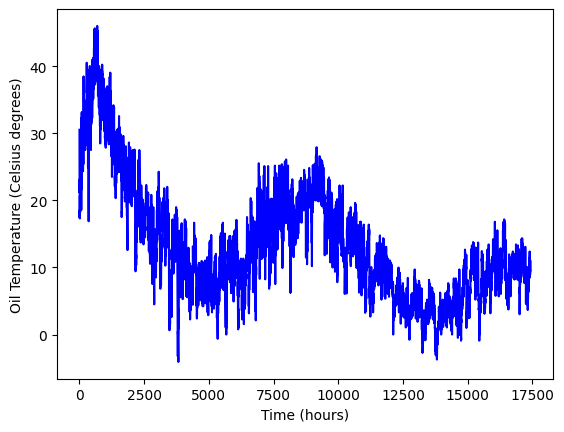

In [2]:
raw = numpy.loadtxt("data/ETTh1.csv", delimiter=",", skiprows=1, usecols=-1)
series = raw.astype(numpy.float32)
plt.plot(series, color='blue')
plt.xlabel("Time (hours)")
plt.ylabel("Oil Temperature (Celsius degrees)")
plt.show()

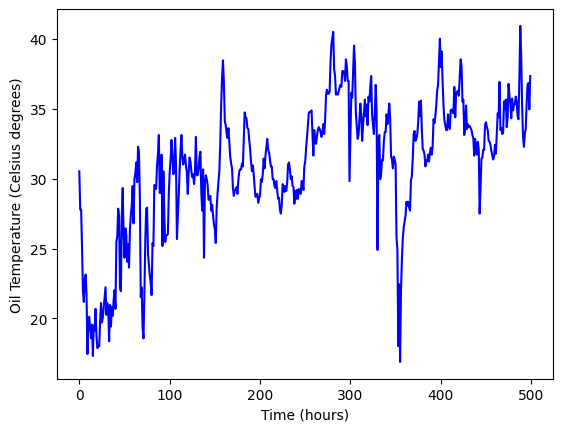

In [3]:
plt.plot(series[:500], color='blue')
plt.xlabel("Time (hours)")
plt.ylabel("Oil Temperature (Celsius degrees)")
plt.show()

**Question 2.** Implement a PyTorch `DataLoader` that reads the CSV file at initialization time, allows you to specify the past window length and forecast horizon, and provides batches of `(past, horizon)` pairs for the univariate forecasting problem.

In [4]:
class ForecastingDataset(torch.utils.data.Dataset):
    """Windowed univariate forecasting dataset."""

    def __init__(self, 
                 csv_path: str, 
                 window: int, 
                 horizon: int, 
                 target_col: int = -1):
        super().__init__()
        raw = numpy.loadtxt(csv_path, delimiter=",", skiprows=1, usecols=target_col)
        series = raw.astype(numpy.float32)
        self.window = window
        self.horizon = horizon
        self.series = series
        self.max_start = len(series) - window - horizon + 1
        if self.max_start < 1:
            raise ValueError("Window + horizon larger than available series length")

    def __len__(self):
        return self.max_start

    def __getitem__(self, idx: int):
        start = idx
        past = self.series[start : start + self.window]
        future = self.series[start + self.window : start + self.window + self.horizon]
        past = torch.from_numpy(past)  # shape: (window,)
        future = torch.from_numpy(future)  # shape: (horizon,)
        return past, future


def build_dataloader(csv_path: str, 
                     window: int, 
                     horizon: int, 
                     batch_size: int = 32, 
                     shuffle: bool = True):
    """Create a DataLoader emitting `(past, horizon)` batches."""
    dataset = ForecastingDataset(csv_path=csv_path, 
                                 window=window, 
                                 horizon=horizon)
    return torch.utils.data.DataLoader(dataset, 
                                       batch_size=batch_size, 
                                       shuffle=shuffle, 
                                       drop_last=False)

**Question 3.** Improve your `build_dataloader` function above to build both a training data loader and a validation data loader. What would be appropriate choices for a clean separation between training and validation datasets?

In [5]:
class ForecastingDataset(torch.utils.data.Dataset):
    """Windowed univariate forecasting dataset."""

    def __init__(self, 
                 csv_path: str, 
                 window: int, 
                 horizon: int, 
                 target_col: int = -1,
                 start: int = 0,
                 end: int = None):
        super().__init__()
        raw = numpy.loadtxt(csv_path, delimiter=",", skiprows=1, usecols=target_col)
        series = raw.astype(numpy.float32)
        if end is None:
            series = series[start:]
        else:
            series = series[start:end]
        self.window = window
        self.horizon = horizon
        self.series = series
        self.max_start = len(series) - window - horizon + 1
        if self.max_start < 1:
            raise ValueError("Window + horizon larger than available series length")

    def __len__(self):
        return self.max_start

    def __getitem__(self, idx: int):
        start = idx
        past = self.series[start : start + self.window]
        future = self.series[start + self.window : start + self.window + self.horizon]
        past = torch.from_numpy(past)  # shape: (window,)
        future = torch.from_numpy(future)  # shape: (horizon,)
        return past, future


def build_dataloader(csv_path: str, 
                     window: int, 
                     horizon: int, 
                     batch_size: int = 32, 
                     shuffle: bool = True):
    """Create a DataLoader emitting `(past, horizon)` batches."""
    dataset = ForecastingDataset(csv_path=csv_path, 
                                 window=window, 
                                 horizon=horizon)
    train_dataset = ForecastingDataset(csv_path=csv_path, 
                                       window=window, 
                                       horizon=horizon,
                                       end=len(dataset) // 5)
    train_dl = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=shuffle, 
                                           drop_last=False)
    valid_dataset = ForecastingDataset(csv_path=csv_path, 
                                       window=window, 
                                       horizon=horizon,
                                       start=len(dataset) // 5)
    valid_dl = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=batch_size, 
                                           shuffle=shuffle, 
                                           drop_last=False)
    return train_dl, valid_dl

## Part 2: First models

In this part, you will build your first few forecasting models, train them, and
experiment with classical detrending techniques used in time series analysis.

**Question 4.** Implement a simple autoregressive (AR) model in `torch`.

The model should:
- take a past window of shape `(batch, window)`
- output a forecast of shape `(batch, horizon)`
- be linear in the inputs

In [6]:
class ARModel(torch.nn.Module):
    """Linear autoregressive model."""

    def __init__(self, window: int, horizon: int):
        super().__init__()
        self.linear = torch.nn.Linear(window, horizon)

    def forward(self, past):
        # past: (batch, window)
        # output: (batch, horizon)
        return self.linear(past)

**Question 5.** Train the AR model using mean squared error (MSE) and evaluate
it on the validation set.

Implement:
- a training loop
- a validation loop
- reporting of train and validation losses

In [7]:
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0

    for past, future in dataloader:
        optimizer.zero_grad()
        pred = model(past)
        loss = criterion(pred, future)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * past.size(0)

    return total_loss / len(dataloader.dataset)


@torch.no_grad()
def eval_epoch(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0

    for past, future in dataloader:
        pred = model(past)
        loss = criterion(pred, future)
        total_loss += loss.item() * past.size(0)

    return total_loss / len(dataloader.dataset)

def train_and_valid_loop(model, train_dl, valid_dl, optimizer, criterion, n_epochs):
    logs = {"train_loss": [], "valid_loss": []}
    print(model.__class__.__name__)
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, train_dl, optimizer, criterion)
        logs["train_loss"].append(train_loss)
        valid_loss = eval_epoch(model, valid_dl, criterion)
        logs["valid_loss"].append(valid_loss)
        print(f"Epoch {epoch:02d} | train={train_loss:.4f} | valid={valid_loss:.4f}")
    return logs

# Example usage
window = 96
horizon = 24
n_epochs = 50

train_dl, valid_dl = build_dataloader(
    csv_path="data/ETTh1.csv",
    window=window,
    horizon=horizon,
    batch_size=64
)

ar_model = ARModel(window, horizon)
optimizer = torch.optim.Adam(ar_model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()
logs_AR = train_and_valid_loop(ar_model, train_dl, valid_dl, optimizer, criterion, n_epochs)

ARModel
Epoch 00 | train=138.4768 | valid=11.2500
Epoch 01 | train=15.4901 | valid=10.5036
Epoch 02 | train=14.5000 | valid=9.9729
Epoch 03 | train=13.6995 | valid=9.4764
Epoch 04 | train=12.9996 | valid=9.0184
Epoch 05 | train=12.3356 | valid=8.6098
Epoch 06 | train=11.7771 | valid=8.2530
Epoch 07 | train=11.2462 | valid=7.9088
Epoch 08 | train=10.7428 | valid=7.6079
Epoch 09 | train=10.4147 | valid=7.3763
Epoch 10 | train=10.0276 | valid=7.1455
Epoch 11 | train=9.7025 | valid=6.9657
Epoch 12 | train=9.4169 | valid=6.7932
Epoch 13 | train=9.1532 | valid=6.6514
Epoch 14 | train=8.9502 | valid=6.5383
Epoch 15 | train=8.7626 | valid=6.4063
Epoch 16 | train=8.7169 | valid=6.3925
Epoch 17 | train=8.5071 | valid=6.2487
Epoch 18 | train=8.2901 | valid=6.1842
Epoch 19 | train=8.2002 | valid=6.0798
Epoch 20 | train=8.0612 | valid=6.0473
Epoch 21 | train=7.9129 | valid=5.9421
Epoch 22 | train=7.8661 | valid=5.8880
Epoch 23 | train=7.8776 | valid=5.8874
Epoch 24 | train=7.7572 | valid=5.7854
Epo

**Question 6.** Add input/output standardization layers.

In [8]:
class StandardScaler(torch.nn.Module):
    """Fixed standardization layer."""

    def __init__(self, mean, std):
        super().__init__()
        self.register_buffer("mean", mean)
        self.register_buffer("std", std)

    def forward(self, x):
        return (x - self.mean) / (self.std + 1e-6)

    def inverse(self, x):
        return x * (self.std + 1e-6) + self.mean

def compute_scaler(dataloader):
    values = []
    for past, future in dataloader:
        values.append(past[:, :1])
    values = torch.cat(values, dim=0)
    mean = values.mean()
    std = values.std()
    return mean, std


class ScaledARModel(ARModel):
    def __init__(self, window, horizon, mean, std):
        super().__init__(window, horizon)
        self.scaler = StandardScaler(mean, std)

    def forward(self, past):
        past_scaled = self.scaler(past)
        pred_scaled = self.linear(past_scaled)
        return self.scaler.inverse(pred_scaled)

# Compute scaler from training data only
mean, std = compute_scaler(train_dl)
scaled_ar_model = ScaledARModel(window, horizon, mean, std)
optimizer = torch.optim.Adam(scaled_ar_model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()
logs_scaledAR = train_and_valid_loop(scaled_ar_model, train_dl, valid_dl, optimizer, criterion, n_epochs)

ScaledARModel
Epoch 00 | train=23.8417 | valid=9.4752
Epoch 01 | train=11.3503 | valid=7.8428
Epoch 02 | train=9.5942 | valid=6.9017
Epoch 03 | train=8.6464 | valid=6.3234
Epoch 04 | train=8.0712 | valid=6.0894
Epoch 05 | train=7.6669 | valid=6.0268
Epoch 06 | train=7.4075 | valid=5.7579
Epoch 07 | train=7.2371 | valid=5.5883
Epoch 08 | train=7.0628 | valid=5.5361
Epoch 09 | train=6.9568 | valid=5.4918
Epoch 10 | train=6.8973 | valid=5.5204
Epoch 11 | train=6.8042 | valid=5.4172
Epoch 12 | train=6.7453 | valid=5.4654
Epoch 13 | train=6.6977 | valid=5.2634
Epoch 14 | train=6.6184 | valid=5.2415
Epoch 15 | train=6.5893 | valid=5.5079
Epoch 16 | train=6.5745 | valid=5.2363
Epoch 17 | train=6.5044 | valid=5.2684
Epoch 18 | train=6.4840 | valid=5.1643
Epoch 19 | train=6.5001 | valid=5.4097
Epoch 20 | train=6.4104 | valid=5.2351
Epoch 21 | train=6.3850 | valid=5.1347
Epoch 22 | train=6.3953 | valid=5.2294
Epoch 23 | train=6.3866 | valid=5.2800
Epoch 24 | train=6.3317 | valid=5.3757
Epoch 25 

**Question 7.** Implement a differencing layer that removes local trends:

  $x_t' = x_t - x_{t-1}$

Then implement the inverse operation (integration) to recover forecasts
back to the original scale.

Experiment with how differencing affects convergence and final error, and 
compare forecasts qualitatively.

In [9]:
class Differencing(torch.nn.Module):
    def forward(self, x):
        # x: (batch, window)
        return x[:, 1:] - x[:, :-1]


class Integration(torch.nn.Module):
    def forward(self, last_value, diffs):
        # last_value: (batch, 1)
        # diffs: (batch, horizon)
        return last_value + torch.cumsum(diffs, dim=1)

class DifferencedScaledARModel(torch.nn.Module):
    def __init__(self, window, horizon, mean, std):
        super().__init__()
        self.scaler = StandardScaler(mean, std)
        self.diff = Differencing()
        self.ar = ARModel(window - 1, horizon)
        self.integrate = Integration()

    def forward(self, past):
        scaled_past = self.scaler(past)
        last_value = scaled_past[:, -1:].detach()
        diffs = self.diff(scaled_past)
        pred_diffs = self.ar(diffs)
        scaled_preds = self.integrate(last_value, pred_diffs)
        return self.scaler.inverse(scaled_preds)

# Compute scaler from training data only
mean, std = compute_scaler(train_dl)
diff_scaled_ar_model = DifferencedScaledARModel(window, horizon, mean, std)
optimizer = torch.optim.Adam(diff_scaled_ar_model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

logs_DifferencedScaledAR = train_and_valid_loop(diff_scaled_ar_model, train_dl, valid_dl, optimizer, criterion, n_epochs)

DifferencedScaledARModel
Epoch 00 | train=10.4374 | valid=6.0691
Epoch 01 | train=7.5909 | valid=5.4852
Epoch 02 | train=7.1232 | valid=5.2434
Epoch 03 | train=6.8339 | valid=5.1257
Epoch 04 | train=6.7138 | valid=5.0260
Epoch 05 | train=6.6165 | valid=4.9892
Epoch 06 | train=6.5555 | valid=4.9542
Epoch 07 | train=6.5129 | valid=4.9306
Epoch 08 | train=6.5250 | valid=4.9447
Epoch 09 | train=6.4908 | valid=4.9154
Epoch 10 | train=6.4711 | valid=4.8987
Epoch 11 | train=6.4038 | valid=4.9283
Epoch 12 | train=6.4003 | valid=4.9745
Epoch 13 | train=6.4010 | valid=4.8746
Epoch 14 | train=6.3978 | valid=4.8990
Epoch 15 | train=6.3611 | valid=4.8717
Epoch 16 | train=6.3752 | valid=4.8868
Epoch 17 | train=6.3581 | valid=4.8630
Epoch 18 | train=6.3384 | valid=4.8575
Epoch 19 | train=6.3085 | valid=4.8722
Epoch 20 | train=6.3370 | valid=4.8494
Epoch 21 | train=6.3665 | valid=4.8568
Epoch 22 | train=6.3409 | valid=4.8513
Epoch 23 | train=6.3296 | valid=4.8384
Epoch 24 | train=6.3024 | valid=4.8552

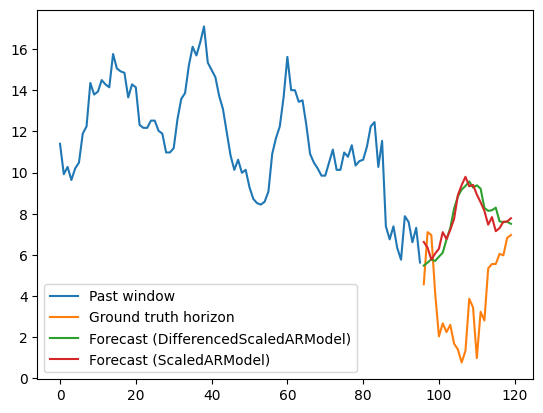

In [10]:
def viz_forecast(list_models: list, dataloader: torch.utils.data.DataLoader, ts_id: int = 0):
    past_val, future_val = next(iter(dataloader))
    plt.plot(numpy.arange(past_val.shape[1]),
            past_val[ts_id],
            label="Past window"
    )
    plt.plot(past_val.shape[1] + numpy.arange(future_val.shape[1]),
            future_val[ts_id],
            label="Ground truth horizon"
    )
    for model in list_models:
        pred_val = model(past_val).detach().numpy()
        plt.plot(past_val.shape[1] + numpy.arange(pred_val.shape[1]),
                pred_val[ts_id],
                label=f"Forecast ({model.__class__.__name__})"
        )
    plt.legend()
    plt.show()

viz_forecast([diff_scaled_ar_model, scaled_ar_model], valid_dl)

**Question 8.** Replace the linear layer in your best-performing AR model with MLPs.

Compare:
- convergence speed
- validation error

In [11]:
class MLP(torch.nn.Module):
    def __init__(self, in_dim, out_dim, hidden=128):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(in_dim, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden, out_dim),
        )

    def forward(self, x):
        return self.net(x)

class DifferencedScaledDeepARModel(DifferencedScaledARModel):
    def __init__(self, window, horizon, mean, std):
        super().__init__(window, horizon, mean, std)
        self.ar = MLP(window - 1, horizon)

# Compute scaler from training data only
mean, std = compute_scaler(train_dl)
diff_scaled_deep_ar_model = DifferencedScaledDeepARModel(window, horizon, mean, std)
optimizer = torch.optim.Adam(diff_scaled_deep_ar_model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

logs_DifferencedScaledDeepAR = train_and_valid_loop(diff_scaled_deep_ar_model, train_dl, valid_dl, optimizer, criterion, n_epochs)

DifferencedScaledDeepARModel
Epoch 00 | train=8.1481 | valid=5.4635
Epoch 01 | train=6.6532 | valid=5.1954
Epoch 02 | train=6.1235 | valid=5.0516
Epoch 03 | train=5.5321 | valid=4.9077
Epoch 04 | train=5.1750 | valid=5.3036
Epoch 05 | train=4.7974 | valid=5.2414
Epoch 06 | train=4.4597 | valid=5.1615
Epoch 07 | train=4.1390 | valid=5.2201
Epoch 08 | train=4.0544 | valid=5.2380
Epoch 09 | train=3.7137 | valid=5.4102
Epoch 10 | train=3.5015 | valid=5.4715
Epoch 11 | train=3.2235 | valid=5.6605
Epoch 12 | train=3.1541 | valid=5.8311
Epoch 13 | train=3.0784 | valid=5.9236
Epoch 14 | train=2.8451 | valid=6.0411
Epoch 15 | train=2.6989 | valid=6.0417
Epoch 16 | train=2.6213 | valid=6.2139
Epoch 17 | train=2.4717 | valid=6.4297
Epoch 18 | train=2.4277 | valid=6.3400
Epoch 19 | train=2.2820 | valid=6.5383
Epoch 20 | train=2.1677 | valid=6.5681
Epoch 21 | train=2.1288 | valid=6.5843
Epoch 22 | train=2.1284 | valid=6.6923
Epoch 23 | train=1.9935 | valid=6.8376
Epoch 24 | train=1.9427 | valid=6.9

**Wrap-up question.** Which factor had the largest impact on performance?
1. model complexity
2. scaling
3. differencing

Justify your answer with quantitative results and/or plots.

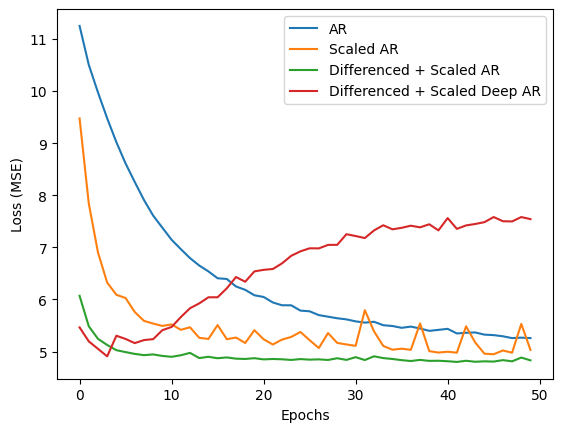

In [12]:
plt.plot(logs_AR["valid_loss"], label="AR")
plt.plot(logs_scaledAR["valid_loss"], label="Scaled AR")
plt.plot(logs_DifferencedScaledAR["valid_loss"], label="Differenced + Scaled AR")
plt.plot(logs_DifferencedScaledDeepAR["valid_loss"], label="Differenced + Scaled Deep AR")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.show()

**Bonus question.** Given what you know about this time series, do you expect seasonality? 
Implement an additional layer for your scaled differenced AR model that performs seasonal differencing using a lag equal to the expected period $\Delta_t$:

$x_t' = x_t - x_{t-\Delta_t}$

Does it help improve overall performance?

In [13]:
class SeasonalDifferencing(torch.nn.Module):
    """Seasonal differencing: x_t' = x_t - x_{t-lag}"""
    
    def __init__(self, lag: int):
        super().__init__()
        self.lag = lag
    
    def forward(self, x):
        return x[:, self.lag:] - x[:, :-self.lag]


class SeasonalIntegration(torch.nn.Module):
    """Inverse of seasonal differencing: x_t = x_{t-lag} + x_t'"""
    
    def __init__(self, lag: int):
        super().__init__()
        self.lag = lag
    
    def forward(self, last_season_values, diff_preds):
        horizon = diff_preds.shape[1]
        preds = []
        extended_history = last_season_values  # (batch, lag)
        
        for t in range(horizon):
            # The base value is from 'lag' steps ago
            if t < self.lag:
                # Use value from last_season_values
                base_value = extended_history[:, t:t+1]
            else:
                # Use previously predicted value
                base_value = preds[t - self.lag]
            
            # Compute prediction: x_t = x_{t-lag} + diff
            new_pred = base_value + diff_preds[:, t:t+1]
            preds.append(new_pred)
        
        return torch.cat(preds, dim=1)


class SeasonalDifferencedScaledARModel(torch.nn.Module):
    """AR model with seasonal differencing and scaling"""
    
    def __init__(self, window: int, horizon: int, mean: float, std: float, lag: int = 24):
        super().__init__()
        assert(lag < window)
        self.scaler = StandardScaler(mean, std)
        self.seasonal_diff = SeasonalDifferencing(lag=lag)
        self.ar = ARModel(window - lag, horizon)  # Window size reduced by lag
        self.seasonal_integrate = SeasonalIntegration(lag=lag)
        self.lag = lag
    
    def forward(self, past):
        scaled_past = self.scaler(past)
        last_season_values = scaled_past[:, -self.lag:].detach() # Save for later (integration)
        seasonally_differenced = self.seasonal_diff(scaled_past)
        pred_diffs = self.ar(seasonally_differenced)
        scaled_preds = self.seasonal_integrate(last_season_values, pred_diffs)
        return self.scaler.inverse(scaled_preds)

# Assuming daily seasonality for hourly data (lag=24 hours)
mean, std = compute_scaler(train_dl)
seasonal_diff_scaled_ar_model = SeasonalDifferencedScaledARModel(
    window=window, 
    horizon=horizon, 
    mean=mean, 
    std=std, 
    lag=24  # Daily seasonality for hourly data
)
optimizer = torch.optim.Adam(seasonal_diff_scaled_ar_model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()
logs_SeasonalDifferencedScaledAR = train_and_valid_loop(
    seasonal_diff_scaled_ar_model, train_dl, valid_dl, optimizer, criterion, n_epochs
)

SeasonalDifferencedScaledARModel
Epoch 00 | train=10.2723 | valid=6.9530
Epoch 01 | train=8.3637 | valid=6.3138
Epoch 02 | train=7.7391 | valid=5.9745
Epoch 03 | train=7.4013 | valid=5.7899
Epoch 04 | train=7.1987 | valid=5.6585
Epoch 05 | train=7.0530 | valid=5.5612
Epoch 06 | train=6.9386 | valid=5.5338
Epoch 07 | train=6.8726 | valid=5.4485
Epoch 08 | train=6.7880 | valid=5.3910
Epoch 09 | train=6.7219 | valid=5.3567
Epoch 10 | train=6.6779 | valid=5.3090
Epoch 11 | train=6.6404 | valid=5.2856
Epoch 12 | train=6.5931 | valid=5.2557
Epoch 13 | train=6.5745 | valid=5.2350
Epoch 14 | train=6.5343 | valid=5.2354
Epoch 15 | train=6.5286 | valid=5.2068
Epoch 16 | train=6.4924 | valid=5.1872
Epoch 17 | train=6.4657 | valid=5.1552
Epoch 18 | train=6.4475 | valid=5.1690
Epoch 19 | train=6.4472 | valid=5.1555
Epoch 20 | train=6.4185 | valid=5.1250
Epoch 21 | train=6.4026 | valid=5.1231
Epoch 22 | train=6.3972 | valid=5.1103
Epoch 23 | train=6.3869 | valid=5.0797
Epoch 24 | train=6.3787 | vali